In [1]:
import numpy as np
np.random.seed(2023)
import random
random.seed(2023)
print('[INFO] Using numpy {0}'.format(np.__version__))

import os
import sys
import time
os.environ['KERAS_BACKEND'] = 'tensorflow'
old_stdout = sys.stdout

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Input, BatchNormalization
from keras import initializers, regularizers, optimizers, losses
#K.set_epsilon(1e-08)
print('[INFO] Using keras {0}'.format(keras.__version__))

import tensorflow as tf
print('[INFO] Using tensorflow {0}'.format(tf.__version__))

import sklearn
#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
print('[INFO] Using sklearn {0}'.format(sklearn.__version__))

import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline


# ______________________________________________________________________________
# Globals
nlayers = 12  # 5 (CSC) + 4 (RPC) + 3 (GEM)

nvariables = 68

discr_pt_cut = 14.

do_skim = False

add_noise = True


[INFO] Using numpy 1.12.1


Using TensorFlow backend.


[INFO] Using keras 2.0.5
[INFO] Using tensorflow 1.1.0
[INFO] Using sklearn 0.18.1


In [2]:
class Encoder(object):

  def __init__(self, x, y, adjust_scale=0):
    if x is not None and y is not None:
      assert(x.shape[1] == (nlayers * 6) + 4)
      assert(y.shape[1] == 3)
      assert(x.shape[0] == y.shape[0])

      self.nentries = x.shape[0]
      self.x_orig  = x
      self.y_orig  = y
      self.x_copy  = x.copy()
      self.y_copy  = y.copy()

      # Get views
      self.x_phi   = self.x_copy[:, nlayers*0:nlayers*1]
      self.x_theta = self.x_copy[:, nlayers*1:nlayers*2]
      self.x_bend  = self.x_copy[:, nlayers*2:nlayers*3]
      self.x_ring  = self.x_copy[:, nlayers*3:nlayers*4]
      self.x_fr    = self.x_copy[:, nlayers*4:nlayers*5]
      self.x_mask  = self.x_copy[:, nlayers*5:nlayers*6].astype(np.bool)  # this makes a copy
      self.x_road  = self.x_copy[:, nlayers*6:nlayers*7]  # ipt, ieta, iphi, iphi_corr
      self.y_pt    = self.y_copy[:, 0]  # q/pT
      self.y_phi   = self.y_copy[:, 1]
      self.y_eta   = self.y_copy[:, 2]
      
      # Make event weight
      #self.w       = np.ones(self.y_pt.shape, dtype=np.float32)
      self.w       = np.abs(self.y_pt)/0.2 + 1.0
      
      # Straightness & zone
      self.x_straightness = self.x_road[:, 0][:, np.newaxis]
      self.x_zone         = self.x_road[:, 1][:, np.newaxis]
      
      # Subtract median phi from hit phis
      #self.x_phi_median    = self.x_road[:, 2] * 32 - 16  # multiply by 'quadstrip' unit (4 * 8)
      self.x_phi_median    = self.x_road[:, 2] * 16 - 8  # multiply by 'doublestrip' unit (2 * 8)
      self.x_phi_median    = self.x_phi_median[:, np.newaxis]
      self.x_phi          -= self.x_phi_median
      
      # Subtract median theta from hit thetas
      self.x_theta_median  = np.nanmedian(self.x_theta[:,:5], axis=1)  # CSC only
      self.x_theta_median[np.isnan(self.x_theta_median)] = np.nanmedian(self.x_theta[np.isnan(self.x_theta_median)], axis=1)  # use all
      self.x_theta_median  = self.x_theta_median[:, np.newaxis]
      self.x_theta        -= self.x_theta_median
      
      # Standard scales
      if adjust_scale == 0:  # do not adjust
        pass
      elif adjust_scale == 1:  # use mean and std
        self.x_mean  = np.nanmean(self.x_copy, axis=0)
        self.x_std   = np.nanstd(self.x_copy, axis=0)
        self.x_std   = self._handle_zero_in_scale(self.x_std)
        self.x_copy -= self.x_mean
        self.x_copy /= self.x_std
      elif adjust_scale == 2:  # adjust by hand
        self.x_phi   *= 0.000991  # GE1/1 dphi linear correlation with q/pT
        self.x_theta *= (1/12.)   # 12 integer theta units
        self.x_bend  *= 0.188082  # ME1/2 bend linear correlation with q/pT
        x_ring_tmp    = self.x_ring.astype(np.int32)
        x_ring_tmp    = (x_ring_tmp == 1) | (x_ring_tmp == 4)
        self.x_ring[x_ring_tmp] = -1  # ring 1,4 -> -1
        self.x_ring[~x_ring_tmp] = 1 # ring 2,3 -> 1
        x_fr_tmp      = self.x_fr.astype(np.int32)
        x_fr_tmp      = (x_fr_tmp == 0)
        self.x_fr[x_fr_tmp] = -1
        self.x_fr[~x_fr_tmp] = 1
      
      # Remove outlier hits by checking hit thetas
      if adjust_scale == 0:  # do not adjust
        x_theta_tmp = np.abs(self.x_theta) > 10000.0
      elif adjust_scale == 1:  # use mean and std
        x_theta_tmp = np.abs(self.x_theta) > 1.0
      elif adjust_scale == 2:  # adjust by hand
        theta_cuts    = np.array((6., 6., 6., 6., 6., 12., 12., 12., 12., 9., 9., 9.), dtype=np.float32)
        theta_cuts   *= (1/12.)   # 12 integer theta units
        assert(len(theta_cuts) == nlayers)
        x_theta_tmp = np.abs(self.x_theta) > theta_cuts
      self.x_phi  [x_theta_tmp] = np.nan
      self.x_theta[x_theta_tmp] = np.nan
      self.x_bend [x_theta_tmp] = np.nan
      self.x_ring [x_theta_tmp] = np.nan
      self.x_fr   [x_theta_tmp] = np.nan
      self.x_mask [x_theta_tmp] = 1.0
      
      # Add variables: straightness, zone, theta_median and mode variables
      self.x_straightness -= 6.  # scaled to [-1,1]
      self.x_straightness /= 6.
      self.x_zone         -= 0.  # scaled to [0,1]
      self.x_zone         /= 5.
      self.x_theta_median -= 3.  # scaled to [0,1]
      self.x_theta_median /= 83.
      hits_to_station = np.array((5,1,2,3,4,1,2,3,4,5,2,5), dtype=np.int32)  # '5' denotes ME1/1
      assert(len(hits_to_station) == nlayers)
      self.x_mode_vars = np.zeros((self.nentries, 5), dtype=np.bool)
      self.x_mode_vars[:,0] = np.any(self.x_mask[:,hits_to_station == 5] == 0, axis=1)
      self.x_mode_vars[:,1] = np.any(self.x_mask[:,hits_to_station == 1] == 0, axis=1)
      self.x_mode_vars[:,2] = np.any(self.x_mask[:,hits_to_station == 2] == 0, axis=1)
      self.x_mode_vars[:,3] = np.any(self.x_mask[:,hits_to_station == 3] == 0, axis=1)
      self.x_mode_vars[:,4] = np.any(self.x_mask[:,hits_to_station == 4] == 0, axis=1)
      self.x_mode_vars[self.x_mode_vars == 0] = -1
      
      # Remove NaN
      #np.nan_to_num(self.x_copy, copy=False)
      self.x_copy[np.isnan(self.x_copy)] = 0.0

  # Copied from scikit-learn
  def _handle_zero_in_scale(self, scale):
    scale[scale == 0.0] = 1.0
    return scale

  def get_x(self):
    #x_new = self.x_phi
    x_new = np.hstack((self.x_phi, self.x_theta, self.x_bend, self.x_ring, self.x_fr, self.x_straightness, self.x_zone, self.x_theta_median, self.x_mode_vars))
    return x_new

  def get_x_mask(self):
    x_mask = self.x_mask.copy()
    return x_mask

  def get_y(self):
    y_new = self.y_pt.copy()
    return y_new

  def get_w(self):
    w_new = self.w.copy()
    return w_new

  def save_encoder(self, filepath):
    np.savez_compressed(filepath, x_mean=self.x_mean, x_std=self.x_std)

  def load_endcoder(self, filepath):
    loaded = np.load(filepath)
    self.x_mean = loaded['x_mean']
    self.x_std = loaded['x_std']

In [3]:
# LeakyReLU with fix
# https://github.com/keras-team/keras/pull/7784

from keras.engine import Layer
from keras import backend as K

class NewLeakyReLU(Layer):
    """Leaky version of a Rectified Linear Unit.
    It allows a small gradient when the unit is not active:
    `f(x) = alpha * x for x < 0`,
    `f(x) = x for x >= 0`.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    # Output shape
        Same shape as the input.
    # Arguments
        alpha: float >= 0. Negative slope coefficient.
    # References
        - [Rectifier Nonlinearities Improve Neural Network Acoustic Models](https://web.stanford.edu/~awni/papers/relu_hybrid_icml2013_final.pdf)
    """

    def __init__(self, alpha=0.3, **kwargs):
        super(NewLeakyReLU, self).__init__(**kwargs)
        self.supports_masking = True
        if isinstance(alpha, dict):
            self.alpha = K.cast_to_floatx(alpha['value'])
        else:
            self.alpha = K.cast_to_floatx(alpha)

    def call(self, inputs):
        return K.relu(inputs, alpha=self.alpha)

    def get_config(self):
        config = {'alpha': float(self.alpha)}
        base_config = super(NewLeakyReLU, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape


# ______________________________________________________________________________
# Huber loss
import tensorflow as tf
from keras import backend as K

def huber_loss(y_true, y_pred, delta=1.345):
  x = K.abs(y_true - y_pred)
  squared_loss = 0.5*K.square(x)
  absolute_loss = delta * (x - 0.5*delta)
  #xx = K.switch(x < delta, squared_loss, absolute_loss)
  xx = tf.where(x < delta, squared_loss, absolute_loss)  # needed for tensorflow
  return K.mean(xx, axis=-1)

#def masked_huber_loss(y_true, y_pred, delta=1.345):
#  x = K.abs(y_true - y_pred)
#  squared_loss = 0.5*K.square(x)
#  absolute_loss = delta * (x - 0.5*delta)
#  #xx = K.switch(x < delta, squared_loss, absolute_loss)
#  xx = tf.where(x < delta, squared_loss, absolute_loss)  # needed for tensorflow
#
#  mask_value = 100.
#  mask = K.equal(y_true, mask_value)
#  mask = 1 - K.cast(mask, K.floatx())
#  return K.sum(xx * mask, axis=-1)


def masked_huber_loss(y_true, y_pred, delta=1.345):
  mask_value = 100.
  mask_alpha = 0.02
  mask = K.equal(y_true, mask_value)
  
  #x = K.abs(y_true - y_pred)
  x = tf.where(mask, mask_alpha * K.abs(0.5 - K.abs(y_pred)), K.abs(y_true - y_pred))
  squared_loss = 0.5*K.square(x)
  absolute_loss = delta * (x - 0.5*delta)
  #xx = K.switch(x < delta, squared_loss, absolute_loss)
  xx = tf.where(x < delta, squared_loss, absolute_loss)  # needed for tensorflow
  return K.mean(xx, axis=-1)


# ______________________________________________________________________________
# Binary crossentropy
import tensorflow as tf
from keras import backend as K

def masked_binary_crossentropy(y_true, y_pred, from_logits=False):
  target, output = y_true, y_pred

  # transform back to logits
  if not from_logits:
    output = K.clip(output, K.epsilon(), 1 - K.epsilon())
    output = K.log(output / (1 - output))
  
  xx =  tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
  #xx =  tf.nn.weighted_cross_entropy_with_logits(targets=target, logits=output, pos_weight=0.5)  # pos_weight < 1 decreases the false positive count

  mask_value = 100.
  mask = K.equal(y_true, mask_value)
  mask = 1 - K.cast(mask, K.floatx())
  return K.sum(xx * mask, axis=-1)


# ______________________________________________________________________________
# Learning rate decay by epoch number
from keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
  if (epoch % 10) == 0:
    lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, lr*0.95)
    print("lr changed to {}".format(lr*0.95))
  return K.get_value(model.optimizer.lr)

lr_decay = LearningRateScheduler(lr_schedule)

In [4]:
#### Load data ####

def muon_data():
  try:
    print('[INFO] Loading muon data ...')
    infile = '../test2/histos_tba.12.npz'
    loaded = np.load(infile)
    the_variables = loaded['variables']
    the_parameters = loaded['parameters']
    print('[INFO] Loaded the variables with shape {0}'.format(the_variables.shape))
    print('[INFO] Loaded the parameters with shape {0}'.format(the_parameters.shape))
  except:
    print('[ERROR] Failed to load data from file: {0}'.format(infile))

  if do_skim:
    the_variables = the_variables[:1000]
    the_parameters = the_parameters[:1000]

  encoder = Encoder(the_variables, the_parameters, adjust_scale=2)
  x, y, w, x_mask = encoder.get_x(), encoder.get_y(), encoder.get_w(), encoder.get_x_mask()
  assert np.isfinite(x).all()

  # Split dataset in training and testing
  x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test = train_test_split(x, y, w, x_mask, test_size=0.4)
  return x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test

# ______________________________________________________________________________
x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test = muon_data()

# Add output nodes
labels = np.where(np.abs(1.0/y_train) > discr_pt_cut, 1., 100.)  # mask_value is set to 100
y_train = [y_train, labels.astype(np.float32)]

labels = np.where(np.abs(1.0/y_test) > discr_pt_cut, 1., 100.)  # mask_value is set to 100
y_test = [y_test, labels.astype(np.float32)]

[INFO] Loading muon data ...
[INFO] Loaded the variables with shape (3646057, 76)
[INFO] Loaded the parameters with shape (3646057, 3)


/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-numpy/1.12.1-mlhled2/lib/python2.7/site-packages/numpy-1.12.1-py2.7-linux-x86_64.egg/numpy/lib/function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/5.0-ghjeda6/lib/python2.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in greater


In [5]:
#### Load data (pileup) ####

def pileup_data():
  try:
    print('[INFO] Loading pileup data ...')
    infile = '../test2/histos_tbd.test.npz'
    loaded = np.load(infile)
    the_variables = loaded['variables']
    the_parameters = np.zeros((the_variables.shape[0], 3), dtype=np.float32)
    the_auxiliaries = loaded['aux']
    print('[INFO] Loaded the variables with shape {0}'.format(the_variables.shape))
    print('[INFO] Loaded the auxiliary info with shape {0}'.format(the_auxiliaries.shape))
  except:
    print('[ERROR] Failed to load data from file: {0}'.format(infile))

  sel = the_auxiliaries[:,2] > discr_pt_cut
  the_variables = the_variables[~sel]
  the_parameters = the_parameters[~sel]
  the_auxiliaries = the_auxiliaries[~sel]

  if do_skim:
    the_variables = the_variables[:1000]
    the_parameters = the_parameters[:1000]
    the_auxiliaries = the_auxiliaries[:1000]

  encoder = Encoder(the_variables, the_parameters, adjust_scale=2)
  x, y, w, x_mask = encoder.get_x(), encoder.get_y(), encoder.get_w(), encoder.get_x_mask()
  aux = the_auxiliaries  # jobid, ievt, highest_part_pt, highest_track_pt
  assert np.isfinite(x).all()
  
  split = the_auxiliaries[:,0] < 50.
  x_train, x_test, aux_train, aux_test = x[split], x[~split], aux[split], aux[~split]
  return x_train, x_test, aux_train, aux_test

# ______________________________________________________________________________
x_adv_train, x_adv_test, aux_adv_train, aux_adv_test = pileup_data()

[INFO] Loading pileup data ...
[INFO] Loaded the variables with shape (170275, 76)
[INFO] Loaded the auxiliary info with shape (170275, 4)


/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/5.0-ghjeda6/lib/python2.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in greater


In [6]:
#### Create a model ####

# See https://keras.io/models/about-keras-models/
#     https://keras.io/layers/about-keras-layers/
#     https://keras.io/getting-started/functional-api-guide/#getting-started-with-the-keras-functional-api

def create_model():
  inputs = Input(shape=(nvariables,), dtype='float32')

  x = Dense(64, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0000))(inputs)
  #x = Dropout(0.2)(x)
  x = Dense(32, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0000))(x)
  #x = Dropout(0.2)(x)
  x = Dense(16, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0000))(x)
  #x = Dropout(0.2)(x)
  
  regr = Dense(1, activation='linear', kernel_initializer='glorot_uniform', name='regr')(x)
  discr = Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform', name='discr')(x)

  # This creates a model that includes
  # the Input layer, three Dense layers and the Output layer
  model = Model(inputs=inputs, outputs=[regr, discr])

  # Set loss and optimizers
  #binary_crossentropy = losses.binary_crossentropy
  #mean_squared_error = losses.mean_squared_error
  
  #adam = optimizers.Adam(lr=0.0001)
  adam = optimizers.Adam(lr=0.001)
  #adam = optimizers.Adam(lr=0.001, amsgrad=True)

  # Compile
  model.compile(optimizer=adam,
    loss={'regr': masked_huber_loss, 'discr': masked_binary_crossentropy},
    loss_weights={'regr': 1.0, 'discr': 0.001},
    #metrics={'regr': ['acc', 'mse', 'mae'], 'discr': ['acc',]}
    )
  return model

def save_model(model):
  # Store model to file
  model.summary()
  model.save('model.h5')
  model.save_weights('model_weights.h5')

  # Store model to json
  import json
  with open('model.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)
  return

# ______________________________________________________________________________
model = create_model()

In [7]:
#### Training Functions ####

# from https://github.com/keras-team/keras/blob/master/keras/utils/generic_utils.py
def slice_arrays(arrays, start=None, stop=None):
    """Slices an array or list of arrays.
    This takes an array-like, or a list of
    array-likes, and outputs:
        - arrays[start:stop] if `arrays` is an array-like
        - [x[start:stop] for x in arrays] if `arrays` is a list
    Can also work on list/array of indices: `_slice_arrays(x, indices)`
    # Arguments
        arrays: Single array or list of arrays.
        start: can be an integer index (start index)
            or a list/array of indices
        stop: integer (stop index); should be None if
            `start` was a list.
    # Returns
        A slice of the array(s).
    """
    if arrays is None:
        return [None]
    elif isinstance(arrays, list):
        if hasattr(start, '__len__'):
            # hdf5 datasets only support list objects as indices
            if hasattr(start, 'shape'):
                start = start.tolist()
            return [None if x is None else x[start] for x in arrays]
        else:
            return [None if x is None else x[start:stop] for x in arrays]
    else:
        if hasattr(start, '__len__'):
            if hasattr(start, 'shape'):
                start = start.tolist()
            return arrays[start]
        elif hasattr(start, '__getitem__'):
            return arrays[start:stop]
        else:
            return [None]


def merge_arrays(arrays, arrays_to_add):
    if isinstance(arrays, list):
        return [None if x is None else np.concatenate((x,y)) for (x,y) in zip(arrays, arrays_to_add)]
    else:
        return [None]

# from https://github.com/keras-team/keras/blob/master/keras/engine/training_utils.py
def make_batches(size, batch_size):
    """Returns a list of batch indices (tuples of indices).
    # Arguments
        size: Integer, total size of the data to slice into batches.
        batch_size: Integer, batch size.
    # Returns
        A list of tuples of array indices.
    """
    num_batches = (size + batch_size - 1) // batch_size  # round up
    return [(i * batch_size, min(size, (i + 1) * batch_size))
            for i in range(num_batches)]

# from https://github.com/keras-team/keras/blob/2.0.5/keras/engine/training.py
import warnings
import copy
from keras import callbacks as cbks
from keras.utils.generic_utils import Progbar

def train(model, x, y, x_adv, aux_adv, batch_size=None, epochs=1, verbose=1, callbacks=None,
          validation_split=0., shuffle=True, class_weight=None, sample_weight=None):

  # Validate user data.
  x, y, sample_weights = model._standardize_user_data(
    x, y,
    sample_weight=sample_weight,
    class_weight=class_weight,
    batch_size=batch_size)
  
  # Prepare input arrays
  if model.uses_learning_phase and not isinstance(K.learning_phase(), int):
    ins = x + y + sample_weights + [1.]
  else:
    ins = x + y + sample_weights
  
  # Prepare validation data.
  do_validation = False
  if validation_split and 0. < validation_split < 1.:
    do_validation = True
    if hasattr(x[0], 'shape'):
      split_at = int(x[0].shape[0] * (1. - validation_split))
    else:
      split_at = int(len(x[0]) * (1. - validation_split))
    x, val_x = (slice_arrays(x, 0, split_at), slice_arrays(x, split_at))
    y, val_y = (slice_arrays(y, 0, split_at), slice_arrays(y, split_at))
    sample_weights, val_sample_weights = (slice_arrays(sample_weights, 0, split_at), slice_arrays(sample_weights, split_at))
    if model.uses_learning_phase and not isinstance(K.learning_phase(), int):
      val_ins = val_x + val_y + val_sample_weights + [0.]
    else:
      val_ins = val_x + val_y + val_sample_weights
  else:
    val_ins = []

  # logic from `_fit_loop()`
  num_train_samples = x[0].shape[0]
  index_array = np.arange(num_train_samples)
  num_test_samples = val_x[0].shape[0]
  val_index_array = np.arange(num_test_samples)
  
  # Callbacks
  out_labels = model.metrics_names
  if do_validation:
    callback_metrics = copy.copy(out_labels) + ['val_' + n for n in out_labels]
  else:
    callback_metrics = copy.copy(out_labels)

  model.history = cbks.History()
  callbacks = [cbks.BaseLogger()] + (callbacks or []) + [model.history]
  if verbose:
    callbacks += [cbks.ProgbarLogger()]
  callbacks = cbks.CallbackList(callbacks)
  callback_model = model
  callbacks.set_model(callback_model)
  callbacks.set_params({
      'batch_size': batch_size,
      'epochs': epochs,
      'samples': num_train_samples,
      'verbose': verbose,
      'do_validation': do_validation,
      'metrics': callback_metrics or [],
  })
  callbacks.on_train_begin()
  callback_model.stop_training = False
  for cbk in callbacks:
      cbk.validation_data = val_ins
  
  
  # Loop over epochs
  for epoch in xrange(epochs):
    epoch_logs = {}
    callbacks.on_epoch_begin(epoch)
    
    if shuffle:
      np.random.shuffle(index_array)
      #np.random.shuffle(val_index_array)
    
    batches = make_batches(num_train_samples, batch_size)
    
    # Loop over batches
    for batch_index, (batch_start, batch_end) in enumerate(batches):
      batch_ids = index_array[batch_start:batch_end]
      if ins and isinstance(ins[-1], float):
        # Do not slice the training phase flag.
        ins_batch = slice_arrays(ins[:-1], batch_ids) + [ins[-1]]
        assert isinstance(ins_batch, list) and len(ins_batch) == 1 + 2 + 2 + 1
      else:
        ins_batch = slice_arrays(ins, batch_ids)
        assert isinstance(ins_batch, list) and len(ins_batch) == 1 + 2 + 2
      
      # Add noise (pileup)
      if add_noise:
        noise = x_adv[np.random.randint(0, x_adv.shape[0], ins_batch[0].shape[0])]
        noise_reg = np.zeros_like(ins_batch[1]) + 100.  # mask_value is set to 100
        noise_discr = np.zeros_like(ins_batch[2])
        noise_reg_w = np.ones_like(ins_batch[3])
        noise_discr_w = np.ones_like(ins_batch[3])
        ins_noise = [noise, noise_reg, noise_discr, noise_reg_w, noise_discr_w]
        if ins and isinstance(ins[-1], float):
          ins_batch = merge_arrays(ins_batch[:-1], ins_noise) + [ins_batch[-1]]
        else:
          ins_batch = merge_arrays(ins_batch, ins_noise)
      
      batch_logs = {}
      batch_logs['batch'] = batch_index
      batch_logs['size'] = len(batch_ids)
      callbacks.on_batch_begin(batch_index, batch_logs)
      
      # Magic
      model._make_train_function()
      f = model.train_function
      outs = f(ins_batch)
      
      if not isinstance(outs, list):
        outs = [outs]
      for l, o in zip(out_labels, outs):
        batch_logs[l] = o
      
      callbacks.on_batch_end(batch_index, batch_logs)
      if callback_model.stop_training:
        break
      
      if batch_index == len(batches) - 1:  # Last batch.
        if do_validation:
          # logic from `_test_loop()`
          val_batches = make_batches(num_test_samples, batch_size)
          val_outs = []
          if verbose == 1:
            progbar = Progbar(target=num_test_samples)
          
          for val_batch_index, (val_batch_start, val_batch_end) in enumerate(val_batches):
            val_batch_ids = val_index_array[val_batch_start:val_batch_end]
            if isinstance(val_ins[-1], float):
              # Do not slice the training phase flag.
              val_ins_batch = slice_arrays(val_ins[:-1], val_batch_ids) + [val_ins[-1]]
            else:
              val_ins_batch = slice_arrays(val_ins, val_batch_ids)
            
            # Magic
            model._make_test_function()
            val_f = model.test_function
            val_batch_outs = val_f(val_ins_batch)
            
            if isinstance(val_batch_outs, list):
              if val_batch_index == 0:
                for i, val_batch_out in enumerate(val_batch_outs):
                  val_outs.append(0.)
              for i, val_batch_out in enumerate(val_batch_outs):
                val_outs[i] += val_batch_out * len(val_batch_ids)
            else:
              if val_batch_index == 0:
                val_outs.append(0.)
              val_outs[0] += val_batch_outs * len(val_batch_ids)
            
            if verbose == 1:
              progbar.update(val_batch_end)
            
          if not isinstance(val_outs, list):
            val_outs = [val_outs]
          # Same labels assumed.
          for l, o in zip(out_labels, val_outs):
            o /= num_test_samples
            o /= 2.  #FIXME
            epoch_logs['val_' + l] = o
            
    callbacks.on_epoch_end(epoch, epoch_logs)
    if callback_model.stop_training:
      break

  callbacks.on_train_end()
  return model.history


In [8]:
#### Training ####

print('[INFO] Begin training ...')
assert keras.backend.backend() == 'tensorflow'

start_time = time.time()
sys.stdout = open('keras_output_1.txt', 'w')
#history = model.fit(x_train, y_train, epochs=40, validation_split=0.1, batch_size=256, verbose=1)
#history = model.fit(x_train, y_train, epochs=400, validation_split=0.1, batch_size=256, callbacks=[lr_decay], verbose=0)
history = train(model, x_train, y_train, x_adv_train, aux_adv_train, epochs=200, validation_split=0.1, batch_size=128, verbose=1)
#history = train(model, x_train, y_train, x_adv_train, aux_adv_train, epochs=400, validation_split=0.1, batch_size=128, callbacks=[lr_decay], verbose=0)
sys.stdout.close()
sys.stdout = old_stdout
print('[INFO] Time elapsed: {0} sec'.format(time.time() - start_time))

save_model(model)
print('[INFO] Done training.')
print('[INFO] Model is saved as model.h5, model.json and model_weights.h5')

[INFO] Begin training ...
[INFO] Time elapsed: 636.236917019 sec
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 68)            0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 64)            4416        input_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 32)            2080        dense_1[0][0]                    
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 16)            528         dense_2[0][0]                    
__________________________

1446000/1458423 [============================>.] - ETA: 0s

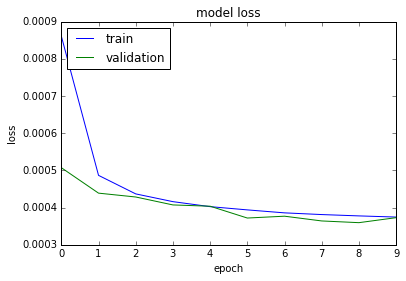

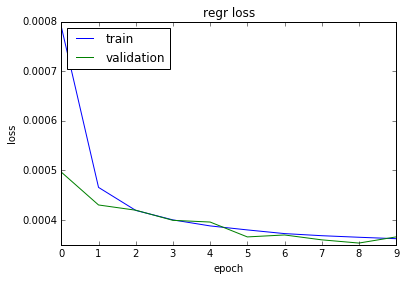

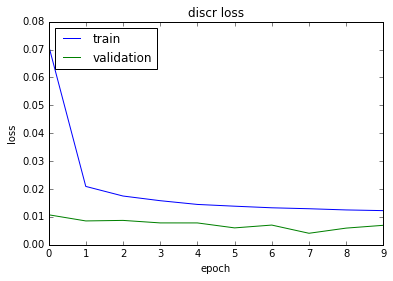

In [9]:
#### Evaluation ####

#loss_and_metrics = model.evaluate(x_test, y_test, sample_weight=w_test, batch_size=1000)
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=1000)
print('[INFO] loss and metrics: {0}'.format(loss_and_metrics))

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['regr_loss'])
plt.plot(history.history['val_regr_loss'])
plt.title('regr loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['discr_loss'])
plt.plot(history.history['val_discr_loss'])
plt.title('discr loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Mean Squared Error
#plt.plot(history.history['regr_mean_squared_error'])
#plt.plot(history.history['val_regr_mean_squared_error'])
#plt.title('regr mse')
#plt.ylabel('mse')
#plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper left')
#plt.show()

## Mean Absolute Error
#plt.plot(history.history['regr_mean_absolute_error'])
#plt.plot(history.history['val_regr_mean_absolute_error'])
#plt.title('regr mae')
#plt.ylabel('mae')
#plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper left')
#plt.show()

## Accuracy
#plt.plot(history.history['discr_acc'])
#plt.plot(history.history['val_discr_acc'])
#plt.title('discr accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper left')
#plt.show()


In [10]:
#### Make plots ####

from keras.models import load_model
import ROOT

# Load model
model_file = 'model.h5'
model_weights_file = 'model_weights.h5'

custom_objects = {'masked_huber_loss': masked_huber_loss, 'masked_binary_crossentropy': masked_binary_crossentropy, 'NewLeakyReLU': NewLeakyReLU}
loaded_model = load_model(model_file, custom_objects=custom_objects)
loaded_model.load_weights(model_weights_file)

# Set styles
ROOT.gROOT.LoadMacro("tdrstyle.C")
ROOT.gROOT.ProcessLine("setTDRStyle();")
ROOT.gStyle.SetPalette(57)  # kBird
ROOT.gStyle.SetMarkerStyle(1)
ROOT.gStyle.SetEndErrorSize(0)
ROOT.gStyle.SetPadGridX(True)
ROOT.gStyle.SetPadGridY(True)

nentries_test = x_test.shape[0]/10
#nentries_test = 100000

y_test_meas = loaded_model.predict(x_test[:nentries_test, :])

y_adv_test = [np.zeros((x_adv_test.shape[0],1), dtype=np.float32), np.zeros((x_adv_test.shape[0],1), dtype=np.float32)]
y_adv_test_meas = loaded_model.predict(x_adv_test)

print y_test_meas
print y_adv_test_meas

Welcome to JupyROOT 6.10/05
[array([[-0.21359947],
       [-0.39531419],
       [ 0.41238287],
       ..., 
       [-0.20836693],
       [ 0.2344631 ],
       [-0.09336649]], dtype=float32), array([[  2.29914649e-03],
       [  3.25185974e-05],
       [  5.36557309e-05],
       ..., 
       [  2.58874730e-04],
       [  1.61316490e-03],
       [  2.21092761e-01]], dtype=float32)]
[array([[ 0.43145153],
       [-0.42545205],
       [ 0.19130552],
       ..., 
       [ 0.11940977],
       [-0.45325685],
       [-0.24693896]], dtype=float32), array([[  1.15602867e-04],
       [  8.09630073e-05],
       [  5.23719657e-03],
       ..., 
       [  1.29964261e-04],
       [  4.49440595e-05],
       [  2.39272427e-04]], dtype=float32)]


145842.0 0.00556767130298 0.0361753240257


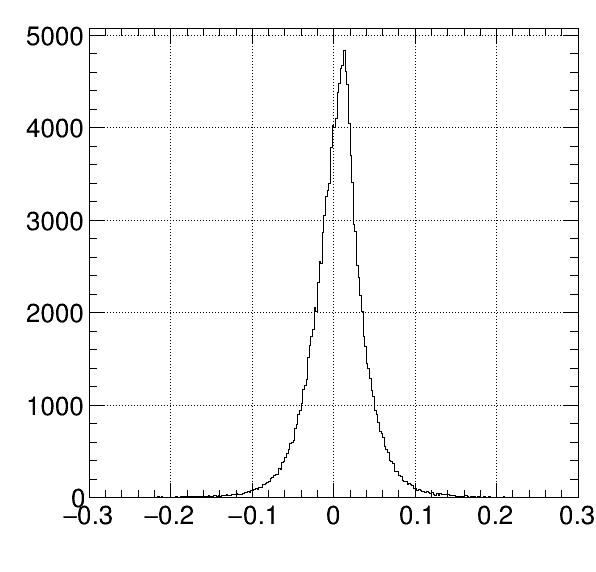

In [11]:
# For regression
h1 = ROOT.TH1F("h1", "h1", 300, -0.3, 0.3)
h2a = ROOT.TH2F("h2a", "h2a", 100, -0.5, 0.5, 300, -0.3, 0.3)
h2b = ROOT.TH2F("h2b", "h2b", 100, -0.5, 0.5, 300, -0.5, 0.5)
h2c = ROOT.TH2F("h2c", "h2c", 100, -0.5, 0.5, 400, -2, 2)
h2d = ROOT.TH2F("h2d", "h2d", 100, -0.5, 0.5, 400, -2, 2)

for i in xrange(nentries_test):
  y_true = y_test[0][i]
  y_meas = y_test_meas[0][i]
  h1.Fill(y_meas - y_true)
  h2a.Fill(y_true, y_meas - y_true) 
  h2b.Fill(y_true, y_meas)
  h2c.Fill(y_true, (y_meas - y_true)/abs(y_true))
  h2d.Fill(abs(y_true), (abs(y_meas) - abs(y_true))/abs(y_true)) 


c = ROOT.TCanvas()
h1.SetMarkerStyle(20)
h1.Draw()
c.Draw()
print h1.GetEntries(), h1.GetMean(), h1.GetRMS()

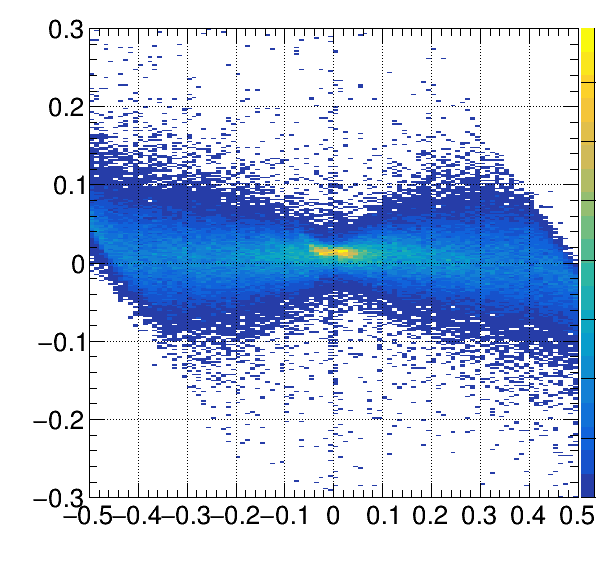

In [12]:
c = ROOT.TCanvas()
h2a.Draw("COLZ")
c.Draw()

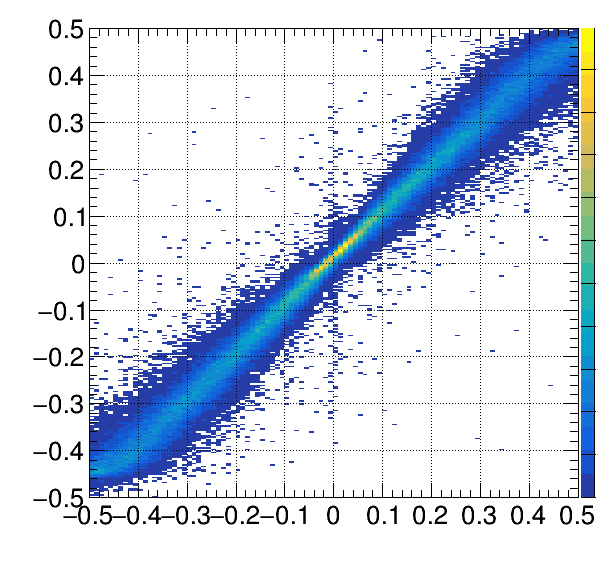

In [13]:
c = ROOT.TCanvas()
h2b.Draw("COLZ")
c.Draw()

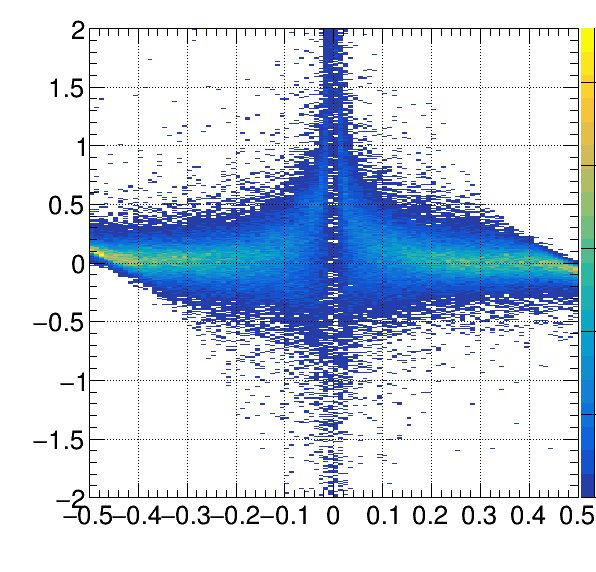

In [14]:
c = ROOT.TCanvas()
h2c.Draw("COLZ")
c.Draw()

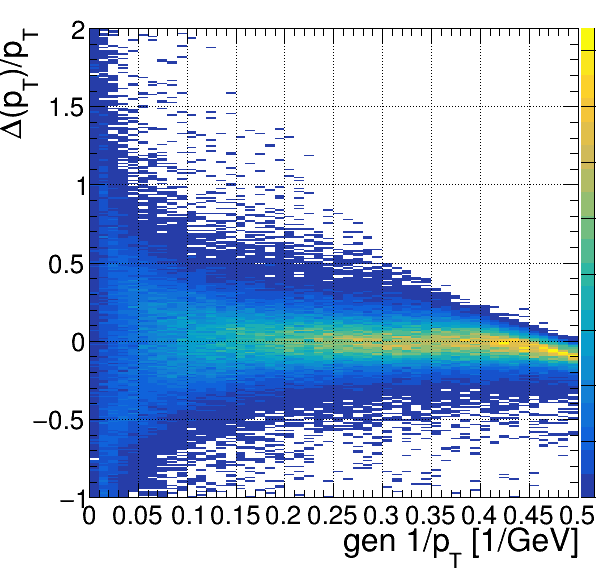

In [15]:
c = ROOT.TCanvas()
h2d.SetStats(0)
h2d.SetTitle("")
h2d.GetXaxis().SetTitle("gen 1/p_{T} [1/GeV]")
h2d.GetYaxis().SetTitle("#Delta(p_{T})/p_{T}")
h2d.GetXaxis().SetRangeUser(0, 0.5)
h2d.GetYaxis().SetRangeUser(-1, 2)
h2d.Draw("COLZ")
c.Draw()

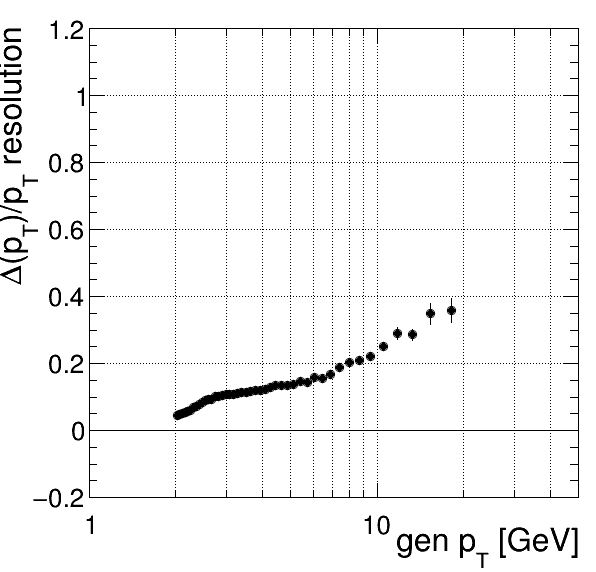

In [16]:
c = ROOT.TCanvas()

hname = "h2d"
h = h2d.Clone("h2d_clone")
#h.Draw("COLZ")
#gPad.Print(hname+".png")
#h.RebinX(2)

#h_pfx = h.ProfileX(hname+"_pfx", 1, -1, "s")
#h_pfx.SetMaximum(1.2)
#h_pfx.SetMinimum(-0.2)
#h_pfx.Draw()
#h_pfx.Fit("pol1", "", "", 0.025, 0.2499)
#gPad.Print(h_pfx.GetName()+".png")
#

if True:
  # Apply gaussian fits
  gr1 = ROOT.TGraphAsymmErrors(h.GetNbinsX())
  gr2 = ROOT.TGraphAsymmErrors(h.GetNbinsX())
  gr1_aspt = ROOT.TGraphAsymmErrors(h.GetNbinsX())
  gr2_aspt = ROOT.TGraphAsymmErrors(h.GetNbinsX())
  for i in xrange(h.GetNbinsX()):
    h_py = h.ProjectionY("_py", i+1, i+1)
    if h_py.Integral() < 15:  continue
    #r = h_py.Fit("gaus", "SNQ")
    r = h_py.Fit("gaus", "SNQ", "", h_py.GetMean() - 0.04*8, h_py.GetMean() + 0.04*8)
    mean, sigma, meanErr, sigmaErr = r.Parameter(1), r.Parameter(2), r.ParError(1), r.ParError(2)
    gr1.SetPoint(i, h.GetXaxis().GetBinCenter(i+1), mean)
    gr1.SetPointError(i, 0, 0, sigma, sigma)
    gr2.SetPoint(i, h.GetXaxis().GetBinCenter(i+1), sigma)
    gr2.SetPointError(i, 0, 0, sigmaErr, sigmaErr)
    gr1_aspt.SetPoint(i, 1.0/h.GetXaxis().GetBinCenter(i+1), mean)
    gr1_aspt.SetPointError(i, 0, 0, sigma, sigma)
    gr2_aspt.SetPoint(i, 1.0/h.GetXaxis().GetBinCenter(i+1), sigma)
    gr2_aspt.SetPointError(i, 0, 0, sigmaErr, sigmaErr)
  #
  hname1 = hname
  h_pfx = h.ProfileX(hname1+"_pfx", 1, -1, "s")
  h_pfx.Reset()
  h_pfx.SetMaximum(1.2)
  h_pfx.SetMinimum(-0.2)
  h_pfx.Draw()
  gr1.SetMarkerStyle(20)
  gr1.Draw("p")
  #gr1.Fit("pol1", "", "", 0.025, 0.2499)
  #gPad.Print(h_pfx.GetName()+".png")
  #
  hname2 = hname
  h_pfx = h.ProfileX(hname2+"_pfx", 1, -1, "s")
  h_pfx.Reset()
  h_pfx.SetMaximum(1)
  h_pfx.SetMinimum(0)
  h_pfx.Draw()
  gr2.SetMarkerStyle(20)
  gr2.Draw("p")
  #gr2.Fit("pol1", "", "", 0.025, 0.2499)
  #gPad.Print(h_pfx.GetName()+".png")
  #
  hname1 = hname
  h_pfx = h.ProfileX(hname1+"_pfx", 1, -1, "s")
  h_pfx.Reset()
  h_pfx.SetBins(50, 0, 50)
  h_pfx.GetXaxis().SetTitle("gen p_{T} [GeV]")
  h_pfx.GetYaxis().SetTitle("#Delta(p_{T})/p_{T} bias")
  h_pfx.SetMaximum(1.2)
  h_pfx.SetMinimum(-0.2)
  h_pfx.Draw()
  gr1_aspt.SetMarkerStyle(20)
  gr1_aspt.Draw("p")
  #gr1_aspt.Fit("pol1", "", "", 0.025, 0.2499)
  #ROOT.gPad.SetLogx(1)
  #ROOT.gPad.Print(h_pfx.GetName()+".png")
  #ROOT.gPad.SetLogx(0)
  #
  hname2 = hname
  h_pfx = h.ProfileX(hname2+"_pfx", 1, -1, "s")
  h_pfx.Reset()
  h_pfx.SetStats(0)
  h_pfx.SetBins(50, 0, 50)
  h_pfx.GetXaxis().SetTitle("gen p_{T} [GeV]")
  h_pfx.GetYaxis().SetTitle("#Delta(p_{T})/p_{T} resolution")
  h_pfx.SetMaximum(1.2)
  h_pfx.SetMinimum(-0.2)
  #h_pfx.SetMaximum(0.1)
  #h_pfx.SetMinimum(-0.01)
  h_pfx.Draw()
  gr2_aspt.SetMarkerStyle(20)
  gr2_aspt.Draw("p")
  #gr2_aspt.Fit("pol1", "", "", 0.025, 0.2499)
  ROOT.gPad.SetLogx(1)
  #ROOT.gPad.Print(h_pfx.GetName()+".png")
  #ROOT.gPad.SetLogx(0)
    
c.Draw()

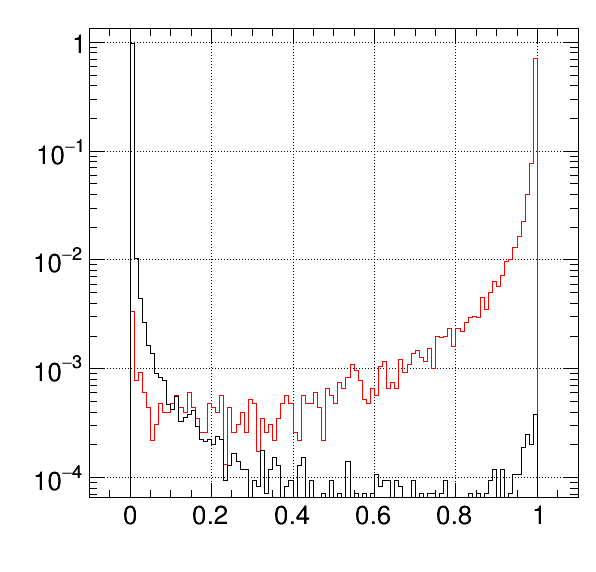

In [17]:
# For classification
hh1a = ROOT.TH1F("hh1a", "hh1a", 120, -0.1, 1.1)
hh1b = ROOT.TH1F("hh1b", "hh1b", 120, -0.1, 1.1)

for i in xrange(nentries_test):
  if y_test[1][i] == 1.0:
    hh1a.Fill(y_test_meas[1][i])

for i in xrange(y_adv_test[1].shape[0]):
  hh1b.Fill(y_adv_test_meas[1][i])


c = ROOT.TCanvas()
hh1a.SetLineColor(632)  # kRed
hh1a.Scale(1.0/hh1a.Integral())
hh1a.Draw("hist")
hh1b.SetLineColor(1)  # kBlack
hh1b.Scale(1.0/hh1b.Integral())
hh1b.Draw("same hist")
c.Draw()
c.SetLogy()

[ 0.90058454  0.92505671  0.95009597  0.97003141  0.98006456  0.98503752
  0.99001047  0.99502705]
[ 0.00143033  0.00182042  0.00241146  0.00368812  0.00478746  0.00615868
  0.00909026  0.02000095]
[ 0.9114635   0.86439431  0.76461452  0.57846689  0.4195399   0.2789143
  0.14361499  0.02798436]


/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-matplotlib/1.5.2-njopjo/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


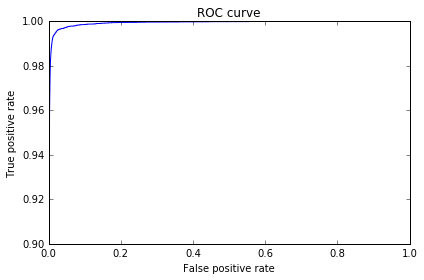

In [18]:
from sklearn.metrics import roc_curve

y_true = np.concatenate((y_test[1][:nentries_test], y_adv_test[1]))
y_pred = np.concatenate((y_test_meas[1], y_adv_test_meas[1]))

mask = (y_true == 100.)  # mask_value is set to 100
y_true = y_true[~mask]
y_pred = y_pred[~mask]

fpr, tpr, thresh = roc_curve(y_true, y_pred)

fig, ax = plt.subplots(tight_layout=True)
ax.plot(fpr, tpr)
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('ROC curve')
ax.set_xlim([0.0,1.0])
ax.set_ylim([0.9,1.0])

idx = np.searchsorted(tpr, [0.9, 0.925, 0.95, 0.97, 0.98, 0.985, 0.99, 0.995])
print tpr[idx]
print fpr[idx]
print thresh[idx]

In [19]:
#### Build trigger ####

class MyTriggerV1(object):
  
  def __init__(self):
    pass

  def get_trigger_pt(self, y_meas):
    pt = np.abs(1.0/y_meas)
    pt_clipped = np.clip(pt, 3., 60.)
    pt = pt * (1.0 + (0.08813 + 0.009504 * pt_clipped) * 1.28155)  # erf(1.28155/sqrt(2)) = 0.8 [90% upper limit from -1 to -1]
    return pt
  
  def pass_trigger(self, x, ndof, y_meas, y_discr):
    trk_mode = 0
    x_mode_vars = x[nlayers*5+3:nlayers*5+8].astype(np.bool)  # convert to booleans
    for i, x_mode_var in enumerate(x_mode_vars):
      if i == 0:
        station = 1
      else:
        station = i
      if x_mode_var:
        trk_mode |= (1 << (4 - station))

    pt_bins = (-0.50, -0.333333, -0.25, -0.20, -0.15, -0.10, -0.05, 0.05, 0.10, 0.15, 0.20, 0.25, 0.333333, 0.50)
    def find_pt_bin(pt):
      ipt = np.digitize((pt,), pt_bins[1:])[0]  # skip lowest edge
      ipt = np.clip(ipt, 0, len(pt_bins)-2)
      return ipt
    def find_road_quality(ipt):
      best_ipt = find_pt_bin(0.)
      return best_ipt - abs(ipt - best_ipt)

    ipt1 = (x[nlayers*5+0:nlayers*5+1] * 6 + 6).astype(np.int32)
    ipt2 = find_pt_bin(y_meas)
    quality1 = find_road_quality(ipt1)
    quality2 = find_road_quality(ipt2)
    
    if trk_mode in (11,13,14,15) and quality2 <= (quality1+1):
      if np.abs(1.0/y_meas) > discr_pt_cut:
        if ndof <= 3:
          #trigger = (y_discr > 0.5)
          trigger = (y_discr > 0.8)
          #trigger = (y_discr > 0.95)
        else:
          trigger = (y_discr > 0.5393)
          #trigger = (y_discr > 0.95)
      else:
        trigger = True
    else:
      trigger = False
    return trigger


class MyTriggerV2(object):
  
  def __init__(self):
    pass

  def get_trigger_pt(self, y_meas):
    pt = np.abs(1.0/y_meas)
    pt_clipped = np.clip(pt, 3., 60.)
    pt = pt * (1.0 + (0.081 + 0.009 * pt_clipped) * 1.28155)  # erf(1.28155/sqrt(2)) = 0.8 [90% upper limit from -1 to -1]
    return pt
  
  def pass_trigger(self, x, ndof, y_meas, y_discr):
    trk_mode = 0
    x_mode_vars = x[nlayers*5+3:nlayers*5+8].astype(np.bool)  # convert to booleans
    for i, x_mode_var in enumerate(x_mode_vars):
      if i == 0:
        station = 1
      else:
        station = i
      if x_mode_var:
        trk_mode |= (1 << (4 - station))
    
    if trk_mode in (11,13,14,15):
      if np.abs(1.0/y_meas) > discr_pt_cut:
        if ndof <= 3:
          #trigger = (y_discr > 0.5)
          trigger = (y_discr > 0.8)
          #trigger = (y_discr > 0.95)
        else:
          trigger = (y_discr > 0.5393)
          #trigger = (y_discr > 0.95)
      else:
        trigger = True
    else:
      trigger = False
    return trigger

# ______________________________________________________________________________
mytrigger = MyTriggerV2()

from rootpy.plotting import Hist, Efficiency
from math import sqrt
histograms = {}


In [20]:
#### Make trigger efficiency ####

eff_pt_bins = (0., 0.5, 1., 2., 3., 4., 5., 6., 8., 10., 12., 14., 16., 18., 20., 22., 24., 26., 28., 30., 35., 40., 45., 50., 60., 80., 120.)

hname = "x_eff_vs_genpt_l1pt20_denom"
h1c_denom = Hist(eff_pt_bins, name=hname, title="; gen p_{T} [GeV]", type='F')
hname = "x_eff_vs_genpt_l1pt20_numer"
h1c_numer = Hist(eff_pt_bins, name=hname, title="; gen p_{T} [GeV]", type='F')

# Loop over events
for x, ndof, y_meas, y_discr, y_true in zip(x_test, x_test, y_test_meas[0], y_test_meas[1], y_test[0]):

  ndof = 4  #FIXME
  
  pt = mytrigger.get_trigger_pt(y_meas)
  
  trigger = mytrigger.pass_trigger(x, ndof, y_meas, y_discr)
  trigger = trigger and (pt > 20.)
  
  pt_true = np.abs(1.0/y_true)
  
  h1c_denom.fill(pt_true)
  if trigger:
    h1c_numer.fill(pt_true)

h1c_eff = Efficiency(h1c_numer, h1c_denom)
h1c_eff.SetStatisticOption(0)  # kFCP
h1c_eff.SetConfidenceLevel(0.682689492137)  # one sigma
h1c_eff.SetMarkerStyle(1)
h1c_eff.SetMarkerColor(800)  # kOrange
h1c_eff.SetLineColor(800)  # kOrange
h1c_eff.SetLineWidth(2)
h1c_eff.SetDirectory(0)
histograms['h1c_numer'] = h1c_numer
histograms['h1c_denom'] = h1c_denom
histograms['h1c_eff'] = h1c_eff

# Add corrections
if False:
  nbinsx = h1c_eff.GetTotalHistogram().GetNbinsX()
  corrections = [0.0, 0.0, 0.0, 2.5596844660416443e-05, 9.071900979369844e-05, -0.00025407866698875234, 3.9318943372533294e-05, 0.00046750609322471475, -0.0012868531325132167, -0.0017629378199139414, -0.003412967281340079, -1.859263302672609e-05, -0.0027697063960877566, -0.011912089953303617, -0.012565904385017701, -0.01502952024543791, -0.007091832957321742, -0.011625792518549893, -0.017156862745097978, -0.007722007722007707, -0.008966446308134701, -0.00857140366324638, -0.021269462895507463, -0.009598486441034226, -0.01485925792486198, -0.010991760558270336]
  assert(len(corrections) == nbinsx)
  for b in xrange(1,nbinsx+1):
    old_eff = h1c_eff.GetEfficiency(b)
    new_eff = old_eff + corrections[b-1]
    h1c_eff.GetPassedHistogram().SetBinContent(b, h1c_eff.GetTotalHistogram().GetBinContent(b) * new_eff)

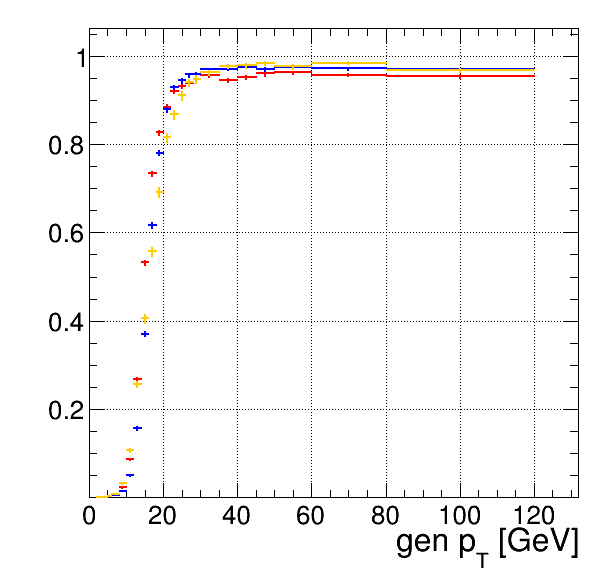

In [21]:
infile1 = ROOT.TFile.Open("emtf_eff_vs_genpt_l1pt20.root")
frame = infile1.Get("emtf_eff_vs_genpt_l1pt20_denom_clone")
h1a_eff = infile1.Get("emtf_eff_vs_genpt_l1pt20_denom_clone")
h1b_eff = infile1.Get("emtf2023_eff_vs_genpt_l1pt20_denom_clone")

c = ROOT.TCanvas()
frame.Draw()
h1a_eff.Draw("same")
h1b_eff.Draw("same")
h1c_eff.Draw("same")
c.Draw()

# Find corrections
if False:
  nbinsx = h1c_eff.GetTotalHistogram().GetNbinsX()
  corrections = []
  for b in xrange(1,nbinsx+1):
    eff1 = h1b_eff.GetEfficiency(b)
    eff2 = h1c_eff.GetEfficiency(b)
    corr = eff1 - eff2
    corrections.append(corr)
  print corrections

In [22]:
#### Make trigger rates ####

hname = "highest_x_absEtaMin0_absEtaMax2.5_qmin12_pt"
rates_hist = Hist(100, 0., 100., name=hname, title="; p_{T} [GeV]; entries", type='F')

rates_nevents = 2000
rates_njobs = 100
rates_array = np.zeros((rates_njobs,rates_nevents), dtype=np.float32)

for x, ndof, y_meas, y_discr, aux in zip(x_adv_test, x_adv_test, y_adv_test_meas[0], y_adv_test_meas[1], aux_adv_test):
  
  ndof = 4  #FIXME
  
  (jobid, ievt, highest_part_pt, highest_track_pt) = aux
  jobid = int(jobid)
  ievt = int(ievt)
  
  pt = mytrigger.get_trigger_pt(y_meas)
  
  trigger = mytrigger.pass_trigger(x, ndof, y_meas, y_discr)

  if trigger:
    rates_array[jobid,ievt] = max(rates_array[jobid,ievt], pt)

rates_nevents_1 = 0

for jobid in xrange(rates_array.shape[0]):
  if rates_array[jobid].sum() > 0.:
    for ievt in xrange(rates_array.shape[1]):
      x = rates_array[jobid,ievt]
      if x > 0.:
        highest_pt = min(100.-1e-3, x)
        rates_hist.fill(highest_pt)
    rates_nevents_1 += rates_nevents

print rates_nevents * rates_njobs, rates_nevents_1


def make_ptcut(h):
  use_overflow = True
  binsum = 0
  binerr2 = 0
  for ib in xrange(h.GetNbinsX()+2-1, 0-1, -1):
    if (not use_overflow) and (ib == 0 or ib == h.GetNbinsX()+1):
      continue
    binsum += h.GetBinContent(ib)
    binerr2 += h.GetBinError(ib)**2
    h.SetBinContent(ib, binsum)
    h.SetBinError(ib, sqrt(binerr2))
  return

def make_rate(h, nevents):
  orbitFreq = 11245.6
  nCollBunches = 1866
  nZeroBiasEvents = nevents
  convFactorToHz = orbitFreq * nCollBunches / nZeroBiasEvents
  h.Scale(convFactorToHz / 1000.)
  return

make_ptcut(rates_hist)
make_rate(rates_hist, rates_nevents_1)

rates_hist.SetLineColor(800)  # kOrange
rates_hist.SetLineWidth(2)
rates_hist.SetDirectory(0)
histograms['rates_hist'] = rates_hist


200000 100000


21.6138191223


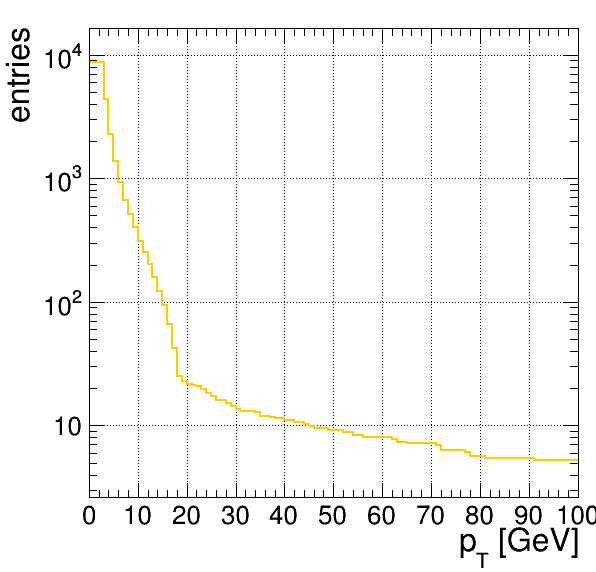

In [23]:
c = ROOT.TCanvas()
rates_hist.Draw("hist")
c.SetLogy()
c.Draw()
print rates_hist.GetBinContent(rates_hist.FindBin(20.))

30.1649169922
22.0335044861
21.6138191223


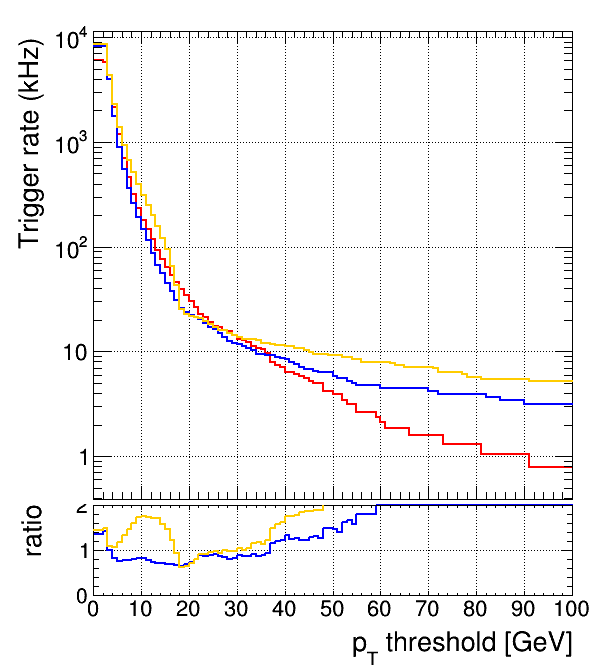

In [24]:
#### Rates ####

infile2 = ROOT.TFile.Open("emtf2023_rate_reduction.root")
#cc1 = infile2.Get("cc1")
denom = infile2.Get("denom")
numer = infile2.Get("numer")
ratio = infile2.Get("ratio")

rates_hist_ratio = rates_hist.Clone("ratio2")
rates_hist_ratio.Divide(rates_hist_ratio, denom, 1, 1, "")

cc1 = ROOT.TCanvas("cc1", "cc1", 600, 700)
cc1.Divide(1,2)
cc1_1 = cc1.GetPad(1)
cc1_1.SetPad(0.01,0.25,0.99,0.99)
cc1_1.SetBottomMargin(0.01)
cc1_1.SetGrid()
cc1_1.SetLogy()
cc1_2 = cc1.GetPad(2)
cc1_2.SetPad(0.01,0.01,0.99,0.25)
cc1_2.SetTopMargin(0.01)
cc1_2.SetBottomMargin(0.43)
cc1_2.SetGrid()

cc1_1.cd()
denom.Draw("hist")
numer.Draw("hist same")
rates_hist.Draw("hist same")
cc1_2.cd()
ratio.Draw("hist same")
rates_hist_ratio.Draw("hist same")
cc1.Draw()

print denom.GetBinContent(denom.FindBin(20.))
print numer.GetBinContent(numer.FindBin(20.))
print rates_hist.GetBinContent(rates_hist.FindBin(20.))

(2187634, 68) (2187634, 1) (2187634, 12)
0 -0.00167623 0.172042 [-0.318111    0.32009301]
1 -0.00513694 0.0597292 [-0.12486599  0.115947  ]
2 -0.00261283 0.0663231 [-0.15063199  0.145677  ]
3 -0.00291088 0.0712192 [-0.15855999  0.15855999]
4 -0.00320962 0.0873563 [-0.20117299  0.190272  ]
5 -0.00542658 0.0525255 [-0.110992  0.103064]
6 -0.00444706 0.0378967 [-0.095136  0.083244]
7 -0.00258608 0.0867003 [-0.194236  0.190272]
8 -0.00262444 0.104559 [-0.221984  0.214056]
9 -0.00215604 0.204676 [-0.36666998  0.36369699]
10 -0.00192914 0.0645558 [-0.14964099  0.14964099]
12 0.101084 0.120319 [-0.08333334  0.41666669]
13 0.102847 0.129742 [-0.08333334  0.45833334]
14 0.00500371 0.0542714 [-0.125  0.125]
15 -0.0297581 0.0568004 [-0.16666667  0.04166667]
16 -0.0334691 0.0797879 [-0.25        0.08333334]
17 0.0644359 0.390407 [-0.70833337  0.83333337]
18 0.07516 0.284995 [-0.5         0.66666669]
19 -0.0345221 0.232304 [-0.5         0.41666669]
20 -0.0143472 0.216704 [-0.5         0.41666669]
2

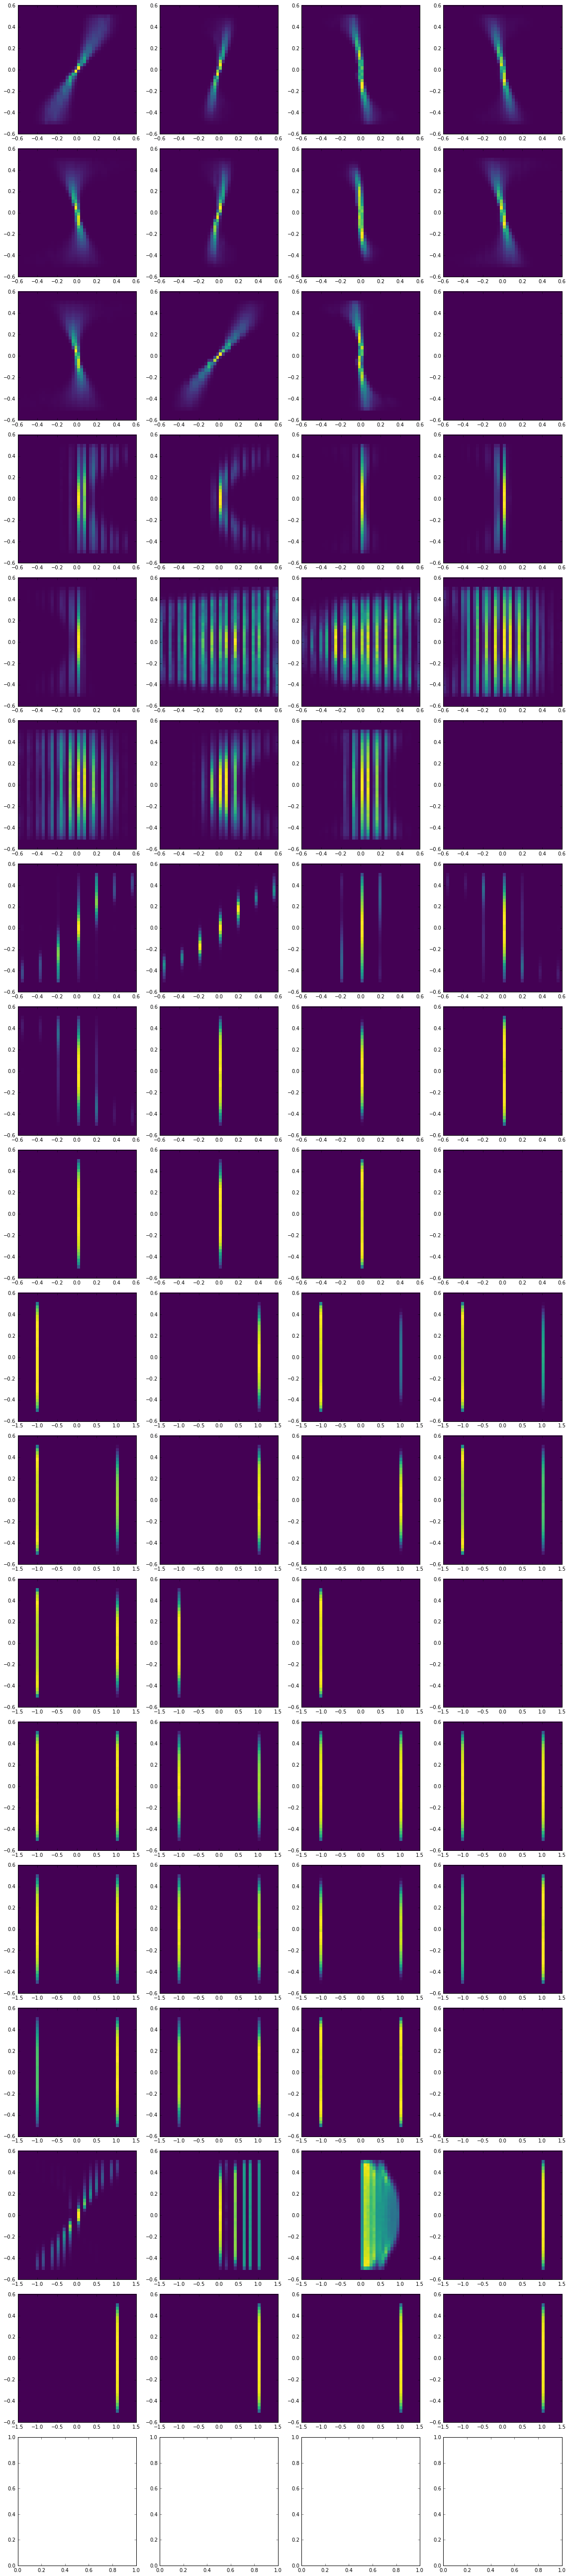

In [25]:
if True:
  print x_train.shape, y_train[0].shape, x_mask_train.shape

  fig, axs = plt.subplots(72/4, 4, figsize=(4*4,4*72/4), tight_layout=True)

  for i in xrange(x_train.shape[1]):
    lay = (i % nlayers)
    mask = x_mask_train[...,lay].copy()
    if i >= (nlayers*5):
      mask *= False
    
    valid = ~mask
    x_i = x_train[valid,i]
    y_i = y_train[0][valid,0]

    #fig, ax = plt.subplots(tight_layout=True)
    xmin, xmax = -0.6, 0.6
    ymin, ymax = -0.6, 0.6
    if (nlayers*3) <= i < (nlayers*5):
      xmin, xmax = -1.5, 1.5
    elif i == 60:
      xmin, xmax = -1.5, 1.5
    elif i == 61:
      xmin, xmax = -1.5, 1.5
    elif i == 62:
      xmin, xmax = -1.5, 1.5
    elif 63 <= i < 68:
      xmin, xmax = -1.5, 1.5
    
    hist = axs[(i/4, i%4)].hist2d(x_i, y_i, bins=40, range=[[xmin, xmax], [ymin, ymax]], cmap=plt.cm.viridis)  #norm=colors.LogNorm(),
    if x_i.size > 0:
      print i, np.mean(x_i), np.std(x_i), np.percentile(x_i, [2,98])